## Dependencies

In [50]:
# pip install plotly
import pandas as pd
import zipfile
import requests
import os
import plotly.io as pio
import numpy as np
import plotly.graph_objs as go
import plotly.offline as offline
import re
import plotly.graph_objs as go

## Download data from S3

Note, the file for the ubuntu data is large - expect the next cell to take several seconds to run.

In [2]:

import requests

print('Beginning data download.')

url = 'https://edgetier.s3-eu-west-1.amazonaws.com/ubunbu-code-test-data/ubuntu_support_extract.csv.zip'  
r = requests.get(url)

with open('./data/ubuntu_support_data.csv.zip', 'wb') as fh:  
    fh.write(r.content)

# Retrieve HTTP meta-data
print(f"Complete, status: {r.status_code}, content:{r.headers['content-type']}")  


Beginning data download.
Complete, status: 200, content:application/zip


## Unzipping data

In [28]:
print ("Unzipping Data")
with zipfile.ZipFile("./data/ubuntu_support_data.csv.zip", 'r') as file:
    file.extractall("./data/")

print("Data unzipped!")
os.listdir("./data")

## Loading data

In [28]:
# Load the data into a pandas data frame and print:
data = pd.read_csv("./data/ubuntu_support_extract.csv")
data.head()

,conversation_id,datetime,from,to,text
0,10-10000,2010-04-17 20:15:00+00:00,fk91,NaN,"Hello, I have a minimal linux system: how can ..."
1,10-10000,2010-04-17 20:15:00+00:00,fk91,NaN,"@Maco: ip is there, thanks :)"
2,10-10000,2010-04-17 20:15:00+00:00,sometux,fk91,ifconfig
3,10-10000,2010-04-17 20:15:00+00:00,sometux,fk91,static or dhcp
4,10-10000,2010-04-17 20:16:00+00:00,fk91,NaN,static


In [29]:
data.shape

(3075574, 5)

# Preprocessing steps


# Task-1

1. Drop NA if data is not available for all the rows. Didn't find any rows as such.
2. Thought of dropping data which are marked as #unbuntu-offtopic but after looking at the data found out that there has been some discussion about ubuntu on those channels. So, decided to keep the data.
3. Since, the task is to get the customer agent for Ubuntu Support, I have selected only those texts where there has been any discussion about unbuntu.
4. Now, to get the top 15 users which will used as customer agent, I have considered the users which have been addressed in "to" or have responded to the message. So, for that I have selected the users from "to" columns which are present in "from".
5. For analysis purpose, I have also checked the count of texts from the each users for each conversation ID and given date and sorted them to find top 15 users. (Faster communication and more responsive)
6. The second method I have applied is to take count of texts for each users and selected top 15 users. (Total count)
7. From the above 2 types of analysis, we could see that the user: sebsebseb has been in top 15 in both the lists with 41 messaged for conversation id:	219-1 and date: 2010-02-13 (if grouped by conversation id and date) and sebsebseb with 1896 message count if seggregated by each user and total text count by them.

### Conclusion:
According to me, top 15 users who were quicker to repond and more responsive should be selected as customer service agent as efficiency and quick response is the key in any customer contact centre. 
So, the top 15 users that were selected are :
sebsebseb,rigved,pjc80la08,chelz,nyqvist,reighnakj,brjannc,aamit1,porg,domedageb,sab1


In [30]:
# Step 2: Clean the data by removing any missing or invalid values.
data=data.dropna(how='all')

In [31]:
data.shape

(3075574, 5)

In [32]:
data.head(5)

,conversation_id,datetime,from,to,text
0,10-10000,2010-04-17 20:15:00+00:00,fk91,NaN,"Hello, I have a minimal linux system: how can ..."
1,10-10000,2010-04-17 20:15:00+00:00,fk91,NaN,"@Maco: ip is there, thanks :)"
2,10-10000,2010-04-17 20:15:00+00:00,sometux,fk91,ifconfig
3,10-10000,2010-04-17 20:15:00+00:00,sometux,fk91,static or dhcp
4,10-10000,2010-04-17 20:16:00+00:00,fk91,NaN,static


In [37]:
# drop #unbuntu-offtopic
# data = data.loc[~data['text'].str.contains(r'^#ubuntu-offtopic\s*', regex=True, case=False, na=False)]

# print the updated dataframe
# data.head(5)

In [38]:
data.shape

(3075098, 5)

In [39]:
filtered_df = data.dropna(subset=['text']).loc[data['text'].str.lower().str.contains('ubuntu', case=False, na=False)]

In [40]:
filtered_df['from'] = filtered_df['from'].str.lower()
filtered_df['to'] = filtered_df['to'].str.lower()
filtered_df

,conversation_id,datetime,from,to,text
22,10-10002,2010-04-17 14:48:00+00:00,tumenjargal,NaN,I'm using firefox 3.5.9 on ubuntu os.
30,10-10003,2010-11-10 16:26:00+00:00,redvil,NaN,hello there..anyone knows an iTunes equivalent...
68,10-10009,2010-04-18 04:32:00+00:00,ken8521,nimbiotics,i used the first post in this thread... very s...
92,10-10012,2010-04-24 15:41:00+00:00,andra,belus,http://ubuntuforums.org/showthread.php?t=11478
97,10-10012,2010-04-24 15:54:00+00:00,andra,NaN,guys I am currently operating ubuntu on a Gate...
...,...,...,...,...,...
3075483,99-9,2010-09-19 17:08:00+00:00,abhijit,ikonia,yah i removed the latest kernel with ubuntu tweak
3075484,99-9,2010-09-19 17:09:00+00:00,ikonia,abhijit,ahhh ubuntu tweak = your system is no longer s...
3075486,99-9,2010-09-19 17:09:00+00:00,ikonia,abhijit,why you felt the need to use ubuntu tweek when...
3075494,99-9,2010-09-19 17:11:00+00:00,abhijit,ikonia,so what you suggest now? should i uninstall ub...


In [41]:
# there are users who have posted and have no resposnse which are nAN in to so considering the common between to and from to get 15 top users
users_present = filtered_df['to'].isin(filtered_df['from'])
filtered_df[users_present]

,conversation_id,datetime,from,to,text
22,10-10002,2010-04-17 14:48:00+00:00,tumenjargal,NaN,I'm using firefox 3.5.9 on ubuntu os.
30,10-10003,2010-11-10 16:26:00+00:00,redvil,NaN,hello there..anyone knows an iTunes equivalent...
68,10-10009,2010-04-18 04:32:00+00:00,ken8521,nimbiotics,i used the first post in this thread... very s...
92,10-10012,2010-04-24 15:41:00+00:00,andra,belus,http://ubuntuforums.org/showthread.php?t=11478
97,10-10012,2010-04-24 15:54:00+00:00,andra,NaN,guys I am currently operating ubuntu on a Gate...
...,...,...,...,...,...
3075483,99-9,2010-09-19 17:08:00+00:00,abhijit,ikonia,yah i removed the latest kernel with ubuntu tweak
3075484,99-9,2010-09-19 17:09:00+00:00,ikonia,abhijit,ahhh ubuntu tweak = your system is no longer s...
3075486,99-9,2010-09-19 17:09:00+00:00,ikonia,abhijit,why you felt the need to use ubuntu tweek when...
3075494,99-9,2010-09-19 17:11:00+00:00,abhijit,ikonia,so what you suggest now? should i uninstall ub...


In [42]:
# changed the data time format to date  data type to get the conversations count.
filtered_df['date'] = pd.to_datetime(filtered_df['datetime']).dt.date
grouped_data = filtered_df.groupby(['conversation_id', 'date','from'])['text'].count().reset_index(name='message_count')


In [43]:
# Sort the data by the number of messages sent in descending order. faster communication and more responsive
grouped_data = grouped_data.sort_values(by=['message_count','date'], ascending=False)
grouped_data = grouped_data.head(15)
grouped_data

,conversation_id,date,from,message_count
62716,219-1,2010-02-13,sebsebseb,41
104502,338-1,2010-05-13,sebsebseb,37
134558,433-1,2010-12-23,rigved,35
62715,219-1,2010-02-13,pjc80la08,29
159318,532-1,2010-06-28,sebsebseb,27
46129,152-4,2010-09-18,chelz,25
134559,433-1,2010-12-24,rigved,19
64459,221-2,2010-02-17,nyqvist,19
103288,315-1,2011-07-10,reighnakj,18
159316,532-1,2010-06-27,sebsebseb,18


In [88]:
# Create a bar trace
trace = go.Bar(
    x=grouped_data['from'],
    y=grouped_data['message_count'],
    text=grouped_data['message_count'],
    textposition='auto'
)

# Create the layout for the plot
layout = go.Layout(
    title='Number of texts by conversation_id and date for each users',
    xaxis=dict(title='Users'),
    yaxis=dict(title='Number of texts')
)

# Create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [90]:
print(grouped_data.describe())

       message_count
count      15.000000
mean       23.400000
std         8.475174
min        16.000000
25%        17.000000
50%        19.000000
75%        28.000000
max        41.000000


In [79]:
pio.renderers.default = 'notebook'

In [81]:
# Create a list of traces, one for each user
# Create a new column combining 'conversation_id' and 'date' as a string
grouped_data['conv_date'] = grouped_data['conversation_id'].astype(str) + ' - ' + grouped_data['date'].astype(str)

# Pivot the dataframe so that 'from' columns become columns in the dataframe
pivot_data = grouped_data.pivot_table(index='conv_date', columns='from', values='message_count', fill_value=0)
traces = []
for user in pivot_data.columns:
    trace = go.Bar(
        x=pivot_data.index,
        y=pivot_data[user],
        name=user,
        hovertemplate='Count: %{y}'      
    )
    traces.append(trace)

# Configure the layout for the plot
layout = go.Layout(
    barmode='stack',
    title='Number of texts by conversation_id and date for each user',
    xaxis=dict(title='Grouped by conversation_id and date'),
    yaxis=dict(title='Number of texts'),
)

# Create the Figure and display it
fig = go.Figure(data=traces, layout=layout)
fig.show()
# offline.plot(fig, filename='stacked_bar_plot.html', auto_open=True)


In [89]:
grouped_data

,conversation_id,date,from,message_count,conv_date
62780,219-1,2010-02-13,sebsebseb,41,219-1 - 2010-02-13
104659,338-1,2010-05-13,sebsebseb,37,338-1 - 2010-05-13
134783,433-1,2010-12-23,rigved,35,433-1 - 2010-12-23
62779,219-1,2010-02-13,pjc80la08,29,219-1 - 2010-02-13
159591,532-1,2010-06-28,sebsebseb,27,532-1 - 2010-06-28
46178,152-4,2010-09-18,chelz,25,152-4 - 2010-09-18
64523,221-2,2010-02-17,nyqvist,19,221-2 - 2010-02-17
134784,433-1,2010-12-24,rigved,19,433-1 - 2010-12-24
159589,532-1,2010-06-27,sebsebseb,18,532-1 - 2010-06-27
103445,315-1,2011-07-10,reighnakj,18,315-1 - 2011-07-10


In [53]:
# Step 3: Group the data by the "from" column to get the number of messages sent by each user.
user_counts = filtered_df.groupby('from').size().reset_index(name='message_count')

In [54]:
# Step 4: Sort the data by the number of messages sent in descending order.
sorted_users = user_counts.sort_values(by='message_count', ascending=False)

In [55]:
sorted_users.head(5)

,from,message_count
14246,floodbot1,4452
846,actionparsnip,4120
4187,bazhang,2788
11416,dr_willis,2781
19427,ikonia,2476


In [56]:
# Step 5: Select the top 15 users based on the number of messages sent.
top_15_users = sorted_users.head(15)

In [57]:
top_15_users

,from,message_count
14246,floodbot1,4452
846,actionparsnip,4120
4187,bazhang,2788
11416,dr_willis,2781
19427,ikonia,2476
14247,floodbot2,1971
14248,floodbot3,1940
38751,sebsebseb,1896
34037,pici,1744
37684,rww,1651


       message_count
count      15.000000
mean     2200.666667
std       989.321533
min      1257.000000
25%      1517.000000
50%      1899.000000
75%      2630.000000
max      4452.000000


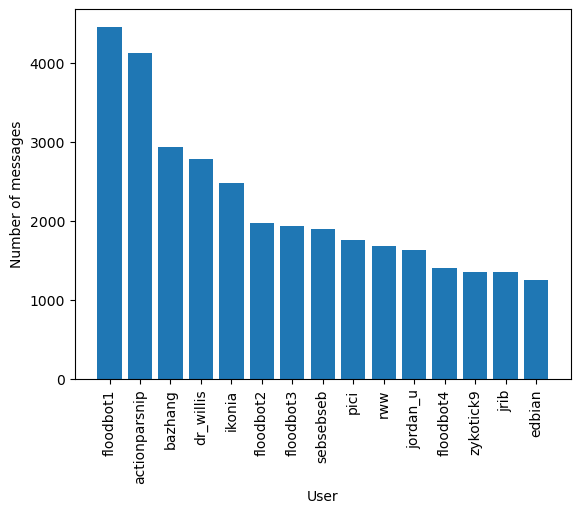

In [64]:
# Now we have our top 15 users based on the number of messages sent.
# We can also create some summary statistics and visualizations to help validate our selection.
import matplotlib.pyplot as plt

# Summary statistics
print(top_15_users.describe())

# Bar chart of top 15 users
plt.bar(top_15_users['from'], top_15_users['message_count'])
plt.xticks(rotation=90)
plt.xlabel('User')
plt.ylabel('Number of messages')
plt.show()

# Task-2

This is a Python function called has_phatic_expression that takes a sentence as input and checks if the sentence contains one or more phatic expressions. Phatic expressions are typically used to establish social relationships and maintain social harmony, rather than to convey any particular meaning.

The steps performed are as mentioned below:
1. The input sentence is split into words using the split() function.
2. The phatic_patterns list contains regular expressions that match different phatic expressions. The function then loops over each word in the sentence, and for each word, it checks if it matches any of the phatic patterns using the re.search() function. If a match is found, the phatic_count variable is incremented by 1.
3. The length of the input sentence is compared with the phatic_count.
4. Finally, the function returns True if any of the following conditions are met:
    1. phatic_count is greater than 1
    2. If they are equal, it means that all the words in the sentence are phatic expressions, so the function returns True. (phatic_count is equal to the number of words in the sentence)
    3. If the phatic_count is greater than 1, or if it is equal to 1 and the input sentence has more than 2 sentences (i.e., if it contains more than 2 periods, exclamation marks, or question marks), the function returns True.
    4. All words in the sentence match one of the phatic patterns, the function returns True.
    5. Otherwise, the function returns False.

Testing the scenarios:
1. For the example sentence "Hello, how are you doing today? Can you please help me with my account?", the condition elif phatic_count == 1 and len(re.split(r'[.?!]', sentence.strip())) > 2 is met, which returns True.
2. For the example sentence "Hey,I need help with my account", the condition if phatic_count > 1 is not met, so it moves to the next condition which is elif phatic_count == 1 and len(re.split(r'[.?!]', sentence.strip())) > 2, which is also not met. Then it checks for the condition elif phatic_count == len(words), which is also not met. Finally, it checks for the condition elif all(re.search(pattern, word, re.IGNORECASE) for pattern in phatic_patterns for word in words), which is also not met. As a result, it returns False.
3. For the example sentence "Hello Hello Hello", the condition elif phatic_count == len(words) is met, which returns True.
4. For the example sentence "Hello", the condition elif phatic_count == len(words) is met, which returns True.

In [91]:
def has_phatic_expression(sentence):
    phatic_patterns = [
        r'\b(hello|hi|hey)\b',
        r'\bhow are you\b',
        r'\bnice to meet you\b',
        r'\bgood morning\b',
        r'\bgood afternoon\b',
        r'\bgood evening\b',
        r'\b(thanks|thank you|cheers)\b',
        r'\b(bye|goodbye)\b',
        r'\bhave a good day\b',
        r'\bnice morning\b'
    ]

    words = sentence.split()
    phatic_count = 0
    for word in words:
        if any(re.search(pattern, word, re.IGNORECASE) for pattern in phatic_patterns):
            phatic_count += 1

    if phatic_count > 1:
        return True
    elif phatic_count == 1 and len(re.split(r'[.?!]', sentence.strip())) > 2:
        return True
    elif phatic_count == len(words):
        return True
    elif all(re.search(pattern, word, re.IGNORECASE) for pattern in phatic_patterns for word in words):
        return True
    else:
        return False



In [92]:
# Test the function
example_sentence = "Hello, how are you doing today? Can you please help me with my account?"
print(has_phatic_expression(example_sentence))  # Should return True

example_sentence = "Hey,I need help with my account"
print(has_phatic_expression(example_sentence))  # Should return False

example_sentence = "Hello Hello Hello"
print(has_phatic_expression(example_sentence))  # Should return True

example_sentence = "Hello"
print(has_phatic_expression(example_sentence))  # Should return True

True
False
True
True
